In [1]:
!gdown 1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG
!gdown 13mdK-jX_eDNa5v-HB34WOS3WNHSru_ir
!gdown 1h9FV9dVvcvLo97reN9_2dbg0QFKyVED2
!gdown 1es9gtEtl1yiX4DVFRI_Qi0fQg0R9qUO2
!unzip -q data


Downloading...
From (original): https://drive.google.com/uc?id=1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG
From (redirected): https://drive.google.com/uc?id=1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG&confirm=t&uuid=001f612b-76a5-43f6-8643-6211b5d2f654
To: /content/data.zip
100% 960M/960M [00:04<00:00, 195MB/s]
Downloading...
From: https://drive.google.com/uc?id=13mdK-jX_eDNa5v-HB34WOS3WNHSru_ir
To: /content/merged.json
100% 2.58M/2.58M [00:00<00:00, 218MB/s]
Downloading...
From: https://drive.google.com/uc?id=1h9FV9dVvcvLo97reN9_2dbg0QFKyVED2
To: /content/val.json
100% 144k/144k [00:00<00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1es9gtEtl1yiX4DVFRI_Qi0fQg0R9qUO2
To: /content/faulty.csv
100% 25.8k/25.8k [00:00<00:00, 85.4MB/s]


In [2]:
!pip -q install transformers openai-clip wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00


In [3]:
from PIL import Image
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm import trange
import clip
from transformers import CLIPProcessor, CLIPModel
from PIL import ImageFile
import random
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import pandas as pd
import os

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
wandb.init(
      project="mlrc",
      name=f"baseline_test",
      config={"learning_rate": 1e-6,"epochs": 1,})

wandb: Currently logged in as: harshvardhanmestha. Use `wandb login --relogin` to force relogin


In [6]:
json_path = '/content/merged.json'
image_path = '/content/data/merged'
val_image_path = '/content/data/VAL'
val_json_path = '/content/val.json'
faulty_path = '/content/faulty.csv'

In [7]:
with open(json_path, 'r') as f:
    input_data = []
    for line in f:
        obj = json.loads(line)
        input_data.append(obj)

faulty = pd.read_csv(faulty_path)
indexes = list(faulty["index"])
json_strs = list(faulty["json_str"])

for i in trange(len(indexes)):
  input_data[int(indexes[i])] = json.loads(json_strs[i])


100%|██████████| 100/100 [00:00<00:00, 67130.35it/s]


In [8]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device, jit=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

100%|███████████████████████████████████████| 890M/890M [00:20<00:00, 44.5MiB/s]


In [9]:
class image_title_dataset():
    def __init__(self, list_image_path,list_txt,list_txt_cf):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.title  = clip.tokenize(list_txt)
        self.cf_title = clip.tokenize(list_txt_cf)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        cf_title = self.cf_title[idx]
        return image, title, cf_title

In [10]:
num2word = {1 : 'one', 2 : 'two', 3 : 'three', 4 : 'four', 5 : 'five',
               6 : 'six', 7 : 'seven', 8 : 'eight', 9 : 'nine', 10 : 'ten'}

In [11]:
def generate_caps(cap,count,counterfactual=False):
  val_caps = []
  if counterfactual==False:
    for c in list(set(range(1,11)) - set([1])):
      val_cap = cap.replace(num2word[count],num2word[c])
      val_caps.append(val_cap)

  if counterfactual==True:
    l = list(set(range(1,11)) - set([1,count]))
    n = random.choice(l)
    val_caps = cap.replace(num2word[count],num2word[n])

  return val_caps

In [12]:
list_image_path = []
list_txt = []
list_txt_cf = []

for item in input_data:
  img_path = image_path +str('/')+ item['pths'].split('/')[-1]
  caption = item['caps'][:110]
  # caption = item['caps']
  counts = item['counts']

  if counts>0:
    cf_cap = generate_caps(caption.lower(),counts,counterfactual=True)
    list_txt_cf.extend([cf_cap] * 5)

  list_image_path.append(img_path)
  list_txt.append(caption)

dataset = image_title_dataset(list_image_path, list_txt, list_txt_cf)
train_dataloader = DataLoader(dataset, batch_size=5, shuffle=False) #Define your own dataloader

# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

if device == "cpu":
  model.double()

# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) # the lr is smaller, more safe for fine tuning to new dataset

# linear = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=5e-6, total_iters=25)
# cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=5,last_epoch=50)
# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[linear,cosine], milestones=[25])

#data check
pbar = tqdm(train_dataloader, total=len(train_dataloader))
for batch in pbar:
  pass

print("\nData and model ready.")




  3%|▎         | 58/2101 [00:02<01:36, 21.20it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2101/2101 [01:28<00:00, 23.84it/s]



Data and model ready.


In [14]:
with open(val_json_path, 'r') as f:
    val_input_data = []
    for line in f:
        obj = json.loads(line)
        val_input_data.append(obj)
all_sims = []
c = 0

with torch.no_grad():
  for i in trange(len(val_input_data)):
    try:
      sims = []
      img = Image.open(val_input_data[i]['pths'])
      val_caps = generate_caps(val_input_data[i]['caps'].lower(),val_input_data[i]['counts'])
      x = preprocess(img).to(device)
      encoded_image = model.encode_image(torch.unsqueeze(x, 0))
      encoded_image = encoded_image.to(device)

      for j in range(9):
        tokenized_text = clip.tokenize(val_caps[j]).to(device)
        encoded_text = model.encode_text(tokenized_text)
        encoded_text = encoded_text.to(device)

        similarity = torch.cosine_similarity(encoded_text, encoded_image)
        sims.append(float(similarity))
      all_sims.append((sims,val_input_data[i]['counts']))
    except:
      c=c+1
      pass

print(len(all_sims))
print(c)


100%|██████████| 540/540 [01:05<00:00,  8.20it/s]


500
40


In [15]:
def get_preds(all_sims):
  y = []
  y_pred = []

  for i in range(len(all_sims)):
    y_pred.append(all_sims[i][0].index(max(all_sims[i][0]))+2)
    y.append(all_sims[i][1])

  return y_pred,y

y_pred,y = get_preds(all_sims)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

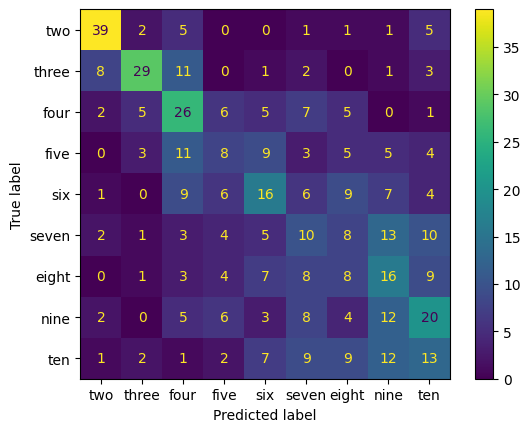

In [16]:
lbls = []
for i in range(len(np.unique(y))):
  lbls.append(num2word[np.unique(y)[i]])

labels = lbls

cf_matrix = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = labels)

cm_display.plot()
plt.savefig(os.path.join(wandb.run.dir, f"count.pdf"))
files.download(os.path.join(wandb.run.dir, f"count.pdf"))
plt.show()



In [ ]:
wandb.finish()

per_epoch_loss,▄▁▃▅▃▃▂▂▃▂▃▂▃▃▅▄▃▃▄▄▅▅▄▆▅▆▅▆▇▆▆▇▇████▇▇█
per_step_loss,▁▁▁▁▂▁▂▁▁▄▁▁▁▁▁▇▂▆▄▅▂▄▁▁▃▃▅▂▂▃▄▄▄▁▂▂▂▂▂█
per_epoch_loss,0.4113
per_step_loss,0.26469
